# About The Dataset: Trending YouTube Video Statistics
This dataset includes several months of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, FR, RU, MX, KR, JP and IN regions (USA, Great Britain, Germany, Canada, France, Russia, Mexico, South Korea, Japan and India respectively), with up to 200 listed trending videos per day. This dataset is a daily record of the top trending YouTube videos published from 07.23.2006 to 06.14.2018.

## Import Libraries, Preprocess and Standardized Data

In [11]:
# Import several helpful libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read and save random 30000 rows of csv file into DataFrame
df2 = pd.read_csv('/kaggle/input/youtube-new/USvideos.csv') 
df1= df2.sample (30000)
# Drop the columns that contain object type data since this algorithm can not process "string" objects. Also data like video_id will not contribute to the algorithm.
df = df1.drop(columns=['video_id', 'title', 'channel_title','tags','trending_date', 'category_id', 'publish_time', 'video_error_or_removed','thumbnail_link', 'description'])

# Outlier detection using Z-scores
z_scores = np.abs(stats.zscore(df[['likes', 'dislikes', 'views', 'comment_count']]))
df = df[(z_scores < 3).all(axis=1)]  # Keep rows where Z-scores are less than 3

## Numerical EDA

In [12]:
# Showing information about df DataFrame such as size
df.info() 

# Print the first 5 rows of the df DataFrame
df.head()

# Check for missing values
df.isna().sum()

# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the dataset for VIF calculation (including the log-transformed columns)
X_vif = df[['likes', 'dislikes', 'comment_count']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['Features'] = X_vif.columns
print(vif)


<class 'pandas.core.frame.DataFrame'>
Index: 29381 entries, 30562 to 1414
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   views              29381 non-null  int64
 1   likes              29381 non-null  int64
 2   dislikes           29381 non-null  int64
 3   comment_count      29381 non-null  int64
 4   comments_disabled  29381 non-null  bool 
 5   ratings_disabled   29381 non-null  bool 
dtypes: bool(2), int64(4)
memory usage: 1.2 MB
        VIF       Features
0  3.183358          likes
1  1.816699       dislikes
2  3.339142  comment_count


After checking Variance Inflation Factor (VIF), we see that there is low multicollinearity and no need to drop any columns.

## Visual EDA

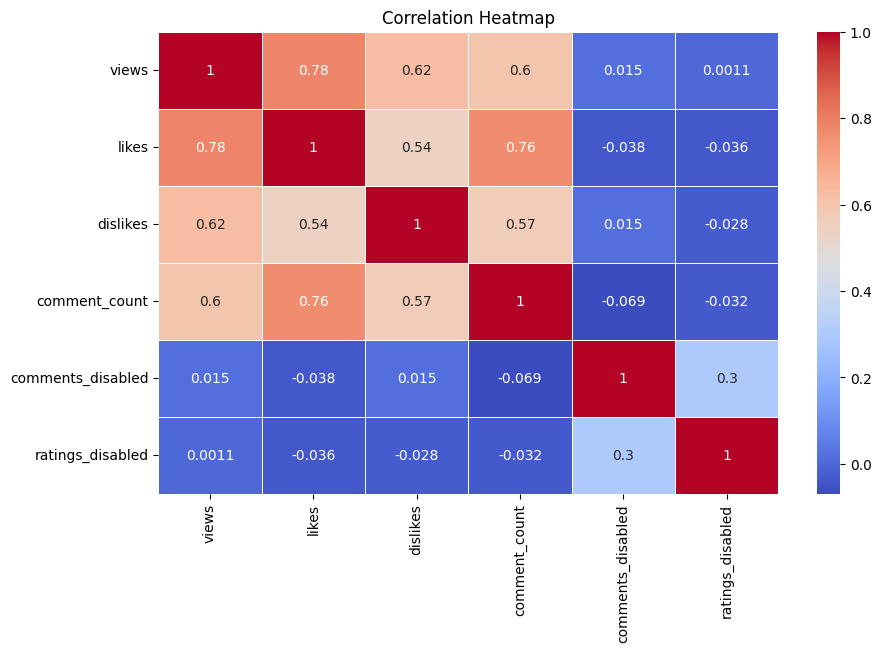

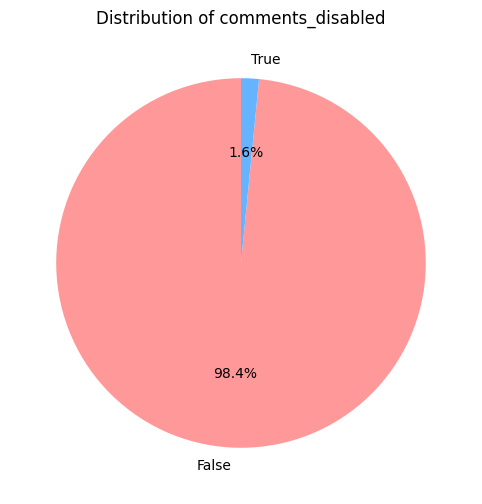

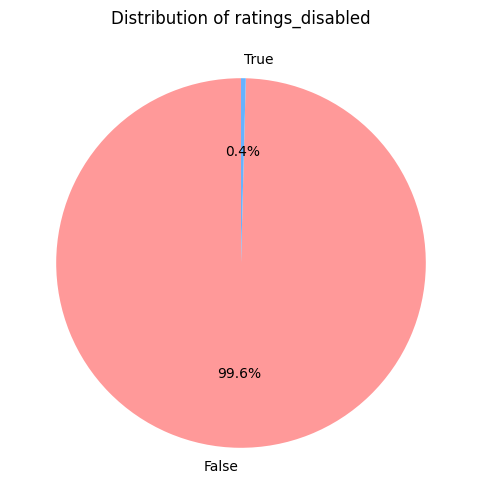

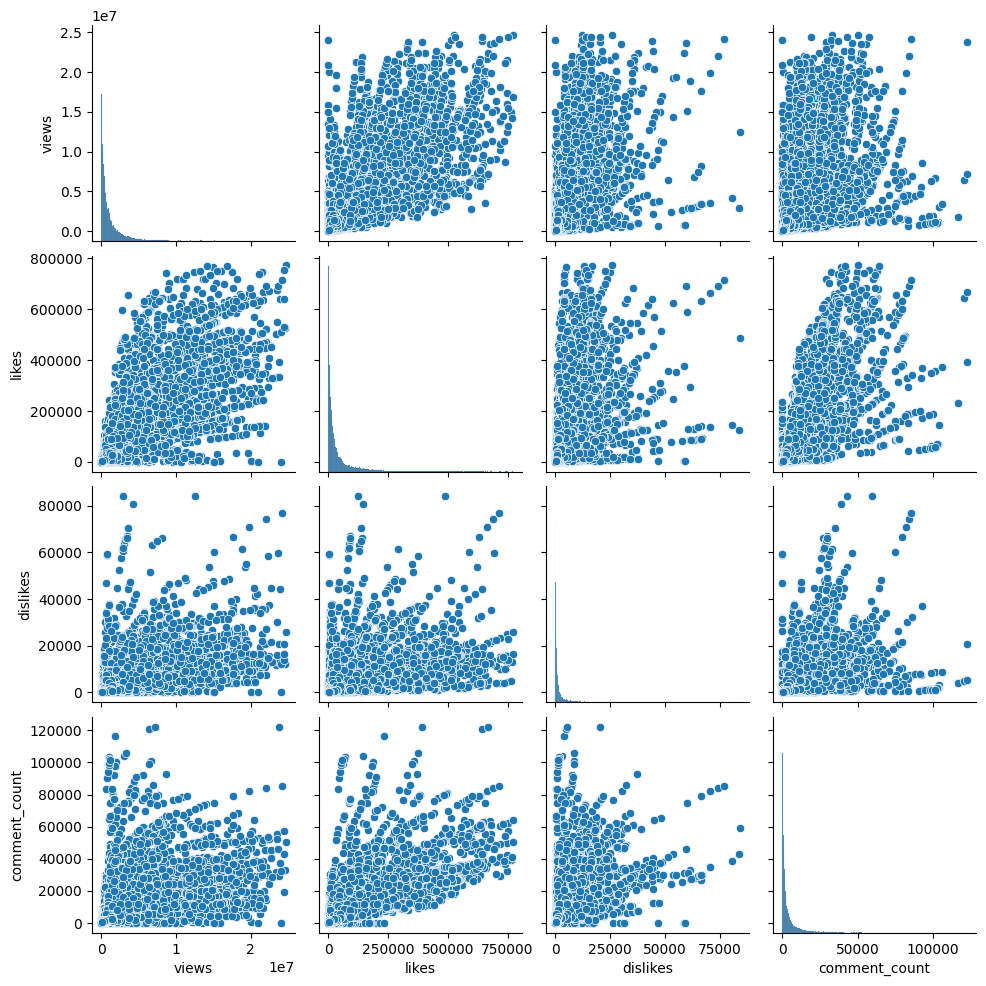

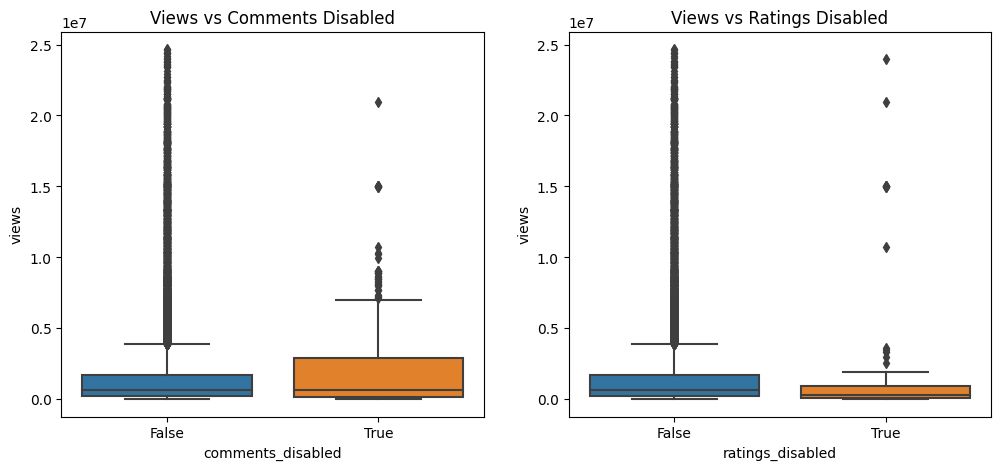

In [13]:
import matplotlib.pyplot as plt

# Visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Assuming 'comments_disabled' and 'ratings_disabled' are boolean features
boolean_features = ['comments_disabled', 'ratings_disabled']

for feature in boolean_features:
    plt.figure(figsize=(8, 6))
    df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
    plt.title(f'Distribution of {feature}')
    plt.ylabel('')  # Hides the y-label
    plt.show()


# Pairplot to visualize the relationship between views and the other numerical features
sns.pairplot(df[['views', 'likes', 'dislikes', 'comment_count']])
plt.show()

# Boxplots to see the relationship of views with boolean features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='comments_disabled', y='views', data=df)
plt.title('Views vs Comments Disabled')

plt.subplot(1, 2, 2)
sns.boxplot(x='ratings_disabled', y='views', data=df)
plt.title('Views vs Ratings Disabled')

plt.show()


# Supervised Learning using Logistic Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# Create an arbitrary engagement score to predict.
df['engagement_score'] = (df['likes'] +df['comment_count']) / df['views']

# Preview the engagement score
df[['views', 'likes','comment_count', 'engagement_score']].head()

# Set a threshold for high engagement
df['high_engagement'] = (df['engagement_score'] > 0.1).astype(int) 

# Check the distribution of high engagement videos
df['high_engagement'].value_counts(normalize=True)

# Define X (features) and y (target)
X = df.drop(columns=['high_engagement', 'engagement_score', 'views']).values  # Predictor variables
y = df['high_engagement'].values                                             # Target variable (high engagement)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)


# Evaluate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming you have y_true (true labels) and y_pred (predicted labels)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# For a detailed report
print(classification_report(y_test, y_pred))


Accuracy: 0.9624503686897334
Confusion Matrix:
 [[8443   16]
 [ 315   41]]
Precision: 0.7192982456140351
Recall: 0.1151685393258427
F1 Score: 0.19854721549636803
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8459
           1       0.72      0.12      0.20       356

    accuracy                           0.96      8815
   macro avg       0.84      0.56      0.59      8815
weighted avg       0.95      0.96      0.95      8815



## Optimize Hyperparameters using Randomized Search

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 100),  # Uniform distribution for regularization strength
    'solver': ['liblinear', 'saga']  # Different solvers
}

# Initialize RandomizedSearchCV with a larger number of iterations and increased max_iter
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to try
    cv=5,
    scoring='accuracy',
    random_state=42
)
random_search.fit(X_scaled, y)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Retrain Logistic Regression with best hyperparameters from RandomizedSearchCV
best_params = random_search.best_params_
clf_optimized = LogisticRegression(C=best_params['C'], solver=best_params['solver'], max_iter=1000)
clf_optimized.fit(X_train, y_train)

# Predict and evaluate again using the optimized model
y_pred_optimized = clf_optimized.predict(X_test)

# Evaluate accuracy and confusion matrix
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("Optimized Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimized))


Best Parameters: {'C': 37.55401188473625, 'solver': 'liblinear'}
Best Score: 0.9623907299550011
Optimized Accuracy: 0.9629041406693136
Optimized Confusion Matrix:
 [[8439   20]
 [ 307   49]]


# Unsupervised Learning using k-Means Clustering
Since unsupervised learning does not use labeled data,remove the labels from the dataset (high_engagement) as well as engagement_score (this column was specifically added for supervised learning) and views (Since this was used to calculate the engagement_score and it was central to the supervised task).

[0.75046597 0.17078603 0.078748  ]
1.0


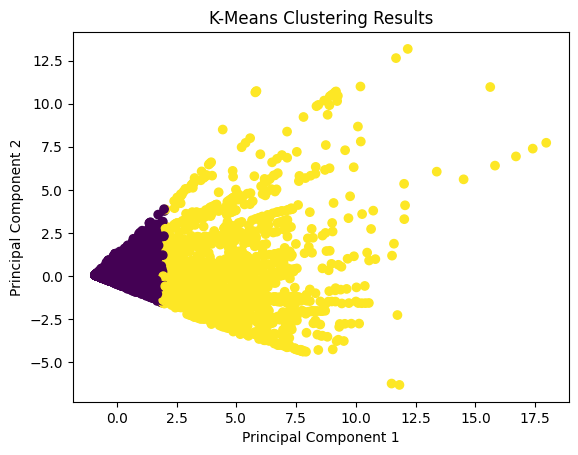

cluster
0    27036
1     2345
Name: count, dtype: int64


In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare the dataset for unsupervised learning by dropping the labeled data
df_unsupervised = df.drop(columns=['high_engagement', 'engagement_score', 'views'])

# Scale the features before clustering
scaler = StandardScaler()
X_unsupervised_scaled = scaler.fit_transform(df_unsupervised[['likes', 'dislikes','comment_count']])  # Keeping relevant numerical columns

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_unsupervised_scaled)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_)) 
# When we set our component number to 3, we can preserve 100% of the total variance.


# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # choose 2 clusters for simplicity and better silhouette score
kmeans.fit(X_pca)

# Add the cluster labels to the DataFrame
df_unsupervised['cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print cluster counts
print(df_unsupervised['cluster'].value_counts())


## Evaluation of the Model

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate K-Means clustering with silhouette score (higher is better)
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Evaluate clustering using Inertia (Within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Inertia (Within-cluster Sum of Squares): {inertia}")

# Evaluate clustering using Davies-Bouldin Index (lower is better)
davies_bouldin = davies_bouldin_score(X_pca, kmeans.labels_)
print(f"Davies-Bouldin Index: {davies_bouldin}")

from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
# Kümeleri değerlendirmek için Adjusted Rand Index kullan
print("Adjusted Rand Index:", adjusted_rand_score(y, kmeans.labels_))
print("Homojenlik Skoru:", homogeneity_score(y, kmeans.labels_))
print("Completentlik Skoru:", completeness_score(y, kmeans.labels_))
print("V-Measure Skoru:", v_measure_score(y, kmeans.labels_))


Silhouette Score: 0.792461461690663
Inertia (Within-cluster Sum of Squares): 42045.69289466719
Davies-Bouldin Index: 0.7493689405215249
Adjusted Rand Index: 0.07465164127514251
Homojenlik Skoru: 0.017862864530248986
Completentlik Skoru: 0.010853665141969936
V-Measure Skoru: 0.013502853743170541
